#### SVI data and death data processing

###### American National Standards Institute (ANSI) Codes for States
###### Virginia:VA: 51
###### Maryland:MD: 24
###### West Virginia:WV: 54
###### District of Columbia:DC: 11

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('../data/SVI 2020 with HepVu/SVI2020_US_county_with_opioid_indicators.shp')

In [4]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['VA', 'MD', 'WV', 'DC'])]

In [5]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

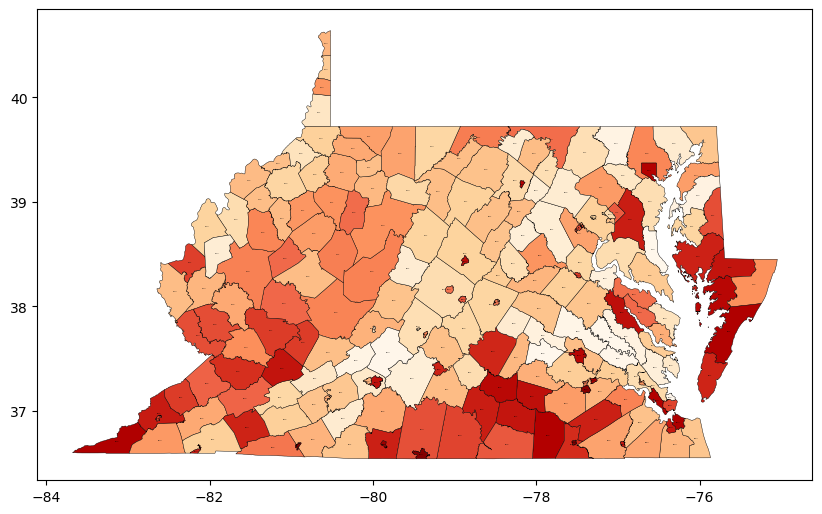

In [6]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [7]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [8]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_OTHERRA,MP_OTHERRA,Shape_Leng,Shape_Area,GEO ID,State Abbr,County Nam,OP_Rate_20,NOD_Rate_2,geometry
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.5,0.1,0.645734,0.018374,11001,DC,District of Col,32.6,58.3,"POLYGON ((-77.11976 38.93434, -77.11253 38.940..."
1,24,Maryland,MD,24001,Allegany,24001,"Allegany County, Maryland",422.203330,71002,0,...,0.1,0.1,2.647485,0.116232,24001,MD,Allegany County,91.0,63.2,"POLYGON ((-79.06756 39.47944, -79.06003 39.492..."
2,24,Maryland,MD,24003,Anne Arundel,24003,"Anne Arundel County, Maryland",414.809757,575421,0,...,0.3,0.1,2.222859,0.121041,24003,MD,Anne Arundel Co,44.0,46.6,"POLYGON ((-76.83849 39.10421, -76.83047 39.106..."


##### Now I need to extract specifically Washington DC Metropolitan Area SVI dataset.

In [9]:
# this contais Washington DC Metro area counties(shapefile)
metro_map_df = gpd.read_file('./data/DC_Metro_counties/Washington_Arlington_Alexandria_DC_VA_MD_WV_Counties.shp')

In [10]:
metro_map_df.head(3)

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,Shape_Area,CBSAFP,METDIVFP,CSAFP,CBSA_Title,M_Status,MDIV_Title,CSA_Title,C_Status,geometry
0,734,54,037,01550025,54037,Jefferson,Jefferson County,06,H1,G4020,...,0.057252,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-78.03541 39.27841, -78.03526 39.278..."
1,1266,24,009,01676636,24009,Calvert,Calvert County,06,H1,G4020,...,0.092340,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-76.56813 38.40771, -76.57181 38.408..."
2,1297,24,033,01714670,24033,Prince George's,Prince George's County,06,H1,G4020,...,0.134028,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Central,"POLYGON ((-77.04202 38.74672, -77.04191 38.750..."


In [11]:
# In the metro shapefile GEOID contains the FIPS code
# metro_svi_deaths will contains SVI and fatalities data for the Washington DC Metro area counties
metro_svi_deaths = filtered_svi_df[filtered_svi_df['FIPS'].isin(metro_map_df['GEOID'].tolist())]
metro_svi_deaths.reset_index(drop=True, inplace=True)

In [14]:
metro_svi_deaths.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_OTHERRA,MP_OTHERRA,Shape_Leng,Shape_Area,GEO ID,State Abbr,County Nam,OP_Rate_20,NOD_Rate_2,geometry
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.5,0.1,0.645734,0.018374,11001,DC,District of Col,32.6,58.3,"POLYGON ((-77.11976 38.93434, -77.11253 38.940..."
1,24,Maryland,MD,24009,Calvert,24009,"Calvert County, Maryland",213.189517,92094,0,...,0.1,0.2,1.392130,0.063610,24009,MD,Calvert County,45.4,34.5,"POLYGON ((-76.70121 38.71276, -76.69914 38.715..."
2,24,Maryland,MD,24017,Charles,24017,"Charles County, Maryland",457.823473,161448,0,...,0.4,0.2,2.164637,0.129562,24017,MD,Charles County,36.9,33.1,"POLYGON ((-77.27382 38.48356, -77.27240 38.489..."


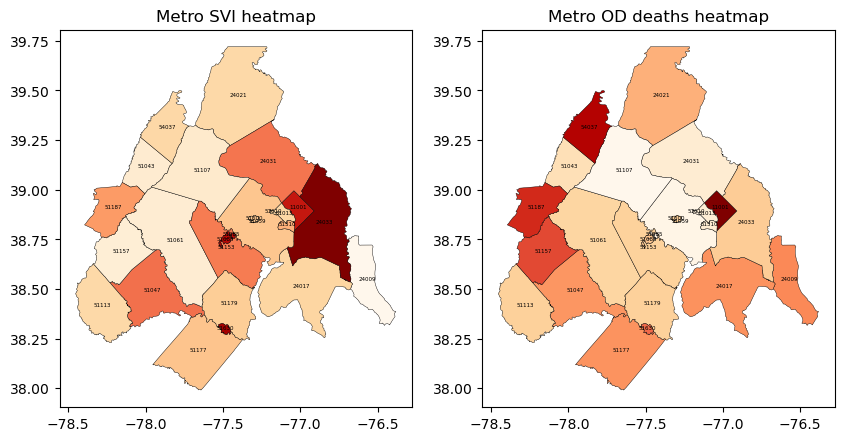

In [15]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = metro_svi_deaths.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('Metro SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = metro_svi_deaths.plot(ax=axes[1], column="NOD_Rate_2", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('Metro OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in metro_svi_deaths.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

#### Saving dataframe to a shapefile

In [18]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(metro_svi_deaths, geometry='geometry')

In [19]:

# Save the GeoDataFrame to a Shapefile
gdf.to_file("./data/processed data/SVI2020 WashingtonDC counties with death rate HepVu/SVI2020_WashingtonDC_counties_with_death_rate_HepVu.shp", driver='ESRI Shapefile')

#### Let's combine rate data and count data into single dataset